**BM20A6100 Advanced Data Analysis and Machine Learning**
*Exercise 1: Nonlinear Dimensionality Reduction*

Toni Koskinen - toni.koskinen@student.lut.fi


In [56]:
#Import libraries
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
from minisom import MiniSom

**Exercise 1**

The task was to compare PCA and t-SNE methods by visualizing Bike Sharing Rental dataset (available at https://www.openml.org/search?type=data&status=active&id=42712&sort=runs)

In [3]:
#Read dataset
arff_file_1 = arff.loadarff("datasets/dataset.arff")
df_1 = pd.DataFrame(arff_file_1[0])
df_1.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,casual,registered,count
0,b'spring',0.0,1.0,0.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.81,0.0,3.0,13.0,16.0
1,b'spring',0.0,1.0,1.0,b'False',6.0,b'False',b'clear',9.02,13.635,0.80,0.0,8.0,32.0,40.0
2,b'spring',0.0,1.0,2.0,b'False',6.0,b'False',b'clear',9.02,13.635,0.80,0.0,5.0,27.0,32.0
3,b'spring',0.0,1.0,3.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.75,0.0,3.0,10.0,13.0
4,b'spring',0.0,1.0,4.0,b'False',6.0,b'False',b'clear',9.84,14.395,0.75,0.0,0.0,1.0,1.0


Before applying any dimensionality reduction techniques, the data was preprocessed:
- Columns with byte string, where converted to string
- Columns with "True"/"False" values were converted to boolean
- Values from season and weather were converted into dummy variables as they were categorical

In [4]:
#Fix columns with byte strings
df_1["season"] = df_1["season"].astype("str")
df_1["holiday"] = df_1["holiday"].astype("str")
df_1["workingday"] = df_1["workingday"].astype("str")
df_1["weather"] = df_1["weather"].astype("str")

#Convert holiday and workingday to boolean
df_1["holiday"] = df_1["holiday"].map({"False": False, "True": True})
df_1["workingday"] = df_1["workingday"].map({"False": False,"True": True})

In [5]:

#Convert season and weather into dummy variables
df_1 = pd.get_dummies(df_1,columns=["season","weather"])
df_1

,year,month,hour,holiday,weekday,workingday,temp,feel_temp,humidity,windspeed,...,registered,count,season_fall,season_spring,season_summer,season_winter,weather_clear,weather_heavy_rain,weather_misty,weather_rain
0,0.0,1.0,0.0,False,6.0,False,9.84,14.395,0.81,0.0000,...,13.0,16.0,False,True,False,False,True,False,False,False
1,0.0,1.0,1.0,False,6.0,False,9.02,13.635,0.80,0.0000,...,32.0,40.0,False,True,False,False,True,False,False,False
2,0.0,1.0,2.0,False,6.0,False,9.02,13.635,0.80,0.0000,...,27.0,32.0,False,True,False,False,True,False,False,False
3,0.0,1.0,3.0,False,6.0,False,9.84,14.395,0.75,0.0000,...,10.0,13.0,False,True,False,False,True,False,False,False
4,0.0,1.0,4.0,False,6.0,False,9.84,14.395,0.75,0.0000,...,1.0,1.0,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,12.0,19.0,False,1.0,True,10.66,12.880,0.60,11.0014,...,108.0,119.0,False,True,False,False,False,False,True,False
17375,1.0,12.0,20.0,False,1.0,True,10.66,12.880,0.60,11.0014,...,81.0,89.0,False,True,False,False,False,False,True,False
17376,1.0,12.0,21.0,False,1.0,True,10.66,12.880,0.60,11.0014,...,83.0,90.0,False,True,False,False,True,False,False,False
17377,1.0,12.0,22.0,False,1.0,True,10.66,13.635,0.56,8.9981,...,48.0,61.0,False,True,False,False,True,False,False,False


The columns "casual", "registered" and "count" were removed from the dataset as count = registered + casual. The count was extracted for to be the ouput variable.

In [54]:
#Extract X and y from the dataset

X = df_1.drop(columns=["casual","registered","count"]).astype(np.float32)
y = df_1["registered"]

In [7]:
#Vector to divide dataset into training and testing sets
msk = (np.array(range(len(X)))/len(X))<0.8


The X was normalized using standardization.

In [8]:
#Normalization
X_mean = np.mean(X,axis=0)
X_std = np.std(X,axis=0)

X_normalized = (X-X_mean)/X_std

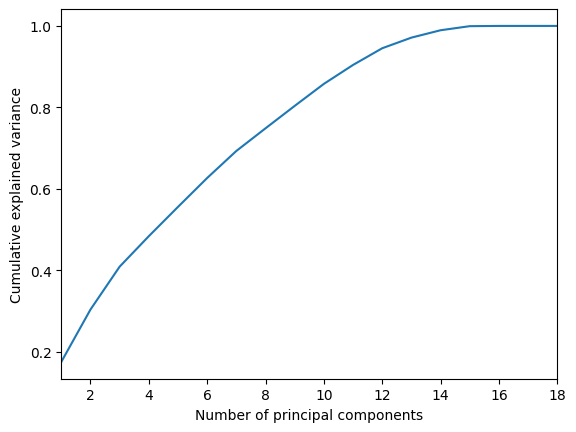

In [38]:
pca = PCA()
pca.fit(X_normalized)

#Save explained variance ratios
explained = pca.explained_variance_ratio_
plt.plot(np.array(range(1,len(explained)+1)),np.cumsum(explained))
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.xlim(1,18)
plt.show()

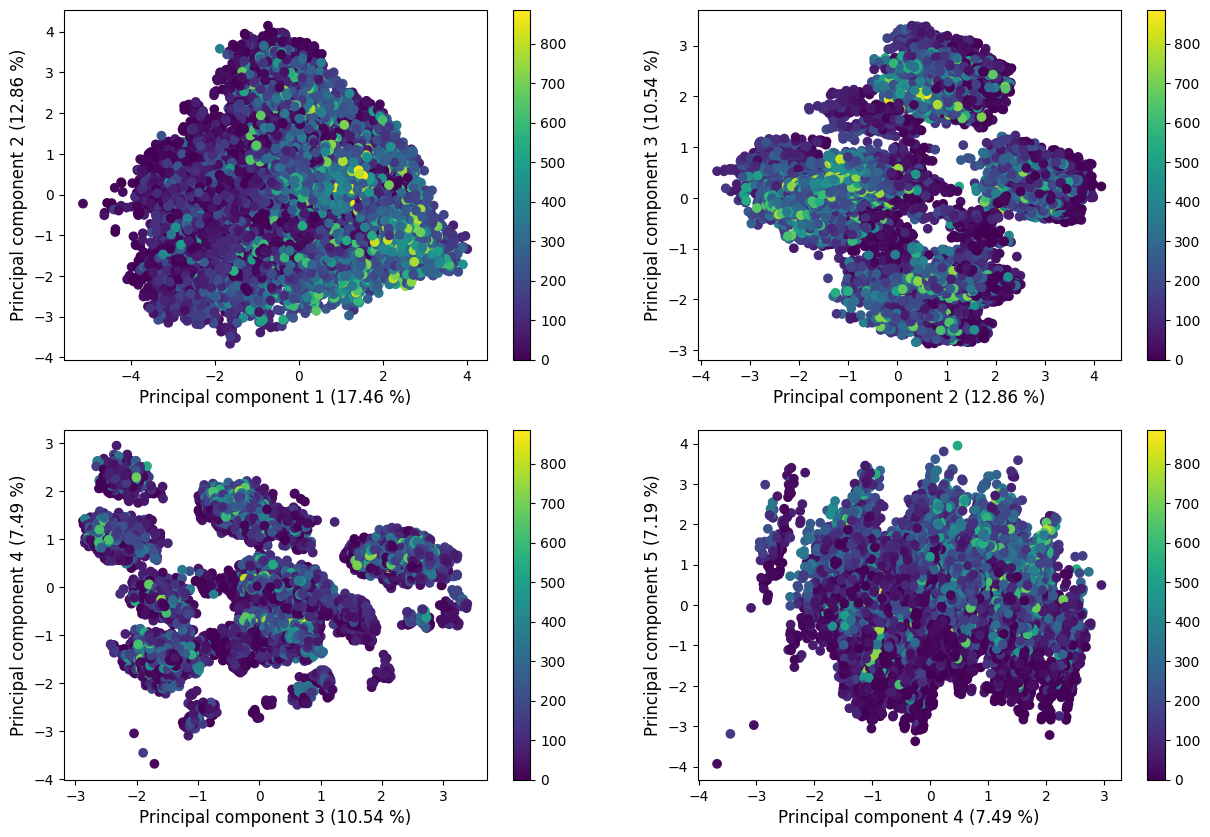

In [10]:
X_pca = pca.transform(X_normalized)

plt.figure(figsize=(15,10))
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.scatter(X_pca[:,i-1],X_pca[:,i],c=y)
    plt.xlabel(f"Principal component {i} ({np.round(100*explained[i-1],2)} %)",fontsize = 12)
    plt.ylabel(f"Principal component {i+1} ({np.round(100*explained[i],2)} %)", fontsize = 12)
    plt.colorbar()

From the visualisation of four largest principal components, it could be seen that in PCA there are no clear clusters formated when plotting two principal components.

In [30]:
tsne = TSNE(n_components=2,random_state=314)
X_tsne = tsne.fit_transform(X_normalized)

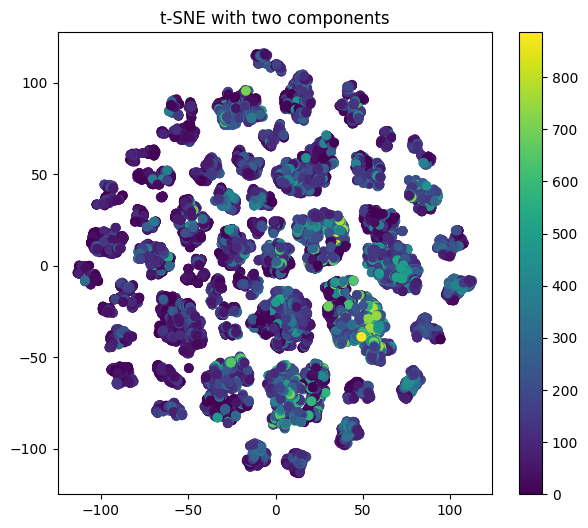

In [35]:
plt.figure(figsize=(7,6))
plt.title("t-SNE with two components")
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=y)
plt.colorbar()
plt.show()

 In the t-SNE there could be seen several small clusters so using that technique we could represent identify local characteristics when performing dimensionality reduction.

Next up, Random Forest Regressors were trained applying both of these techniques. In both approaches, two components were used. The used dataset was divided into training (80 %) and testing (20 %)

In [13]:
#Train models using both dr methods
RFR_pca = RandomForestRegressor()
RFR_pca.fit(X_pca[msk,:2],y[msk])
RFR_tsne = RandomForestRegressor()
RFR_tsne.fit(X_tsne[msk],y[msk])

RandomForestRegressor()

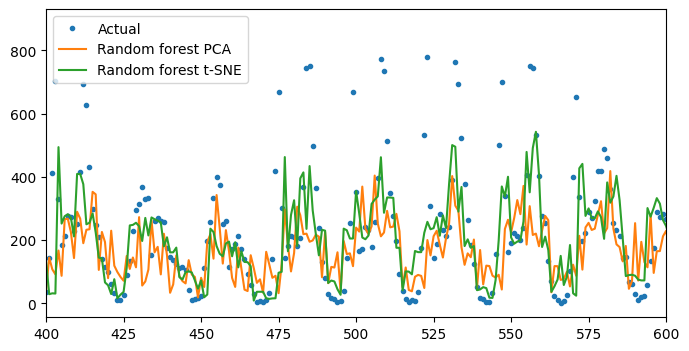

R^2 for PCA approach: 0.04
R^2 for t-SNE approach: 0.02


In [57]:
#Calculate predictions and visualize
pred_pca = RFR_pca.predict(X_pca[~msk,:2])
pred_tsne = RFR_tsne.predict(X_tsne[~msk])
plt.figure(figsize=(8,4))
plt.plot(y[~msk].to_numpy(),'.',label="Actual")
plt.plot(pred_pca,label="Random forest PCA")
plt.plot(pred_tsne,label="Random forest t-SNE")
plt.xlim(400,600)
plt.legend()
plt.show()
R2_pca = explained_variance_score(y[~msk],pred_pca)
R2_tsne = explained_variance_score(y[~msk],pred_tsne)

print(f"R^2 for PCA approach: {np.round(R2_pca,2)}")
print(f"R^2 for t-SNE approach: {np.round(R2_tsne,2)}")

From the explained variance ratios (R^2), it could be noticed that neither of the models performs well for the test data. Visually t-SNE approach seemed to produce more accurate results than the PCA approach but R^2 values don't support this argument.

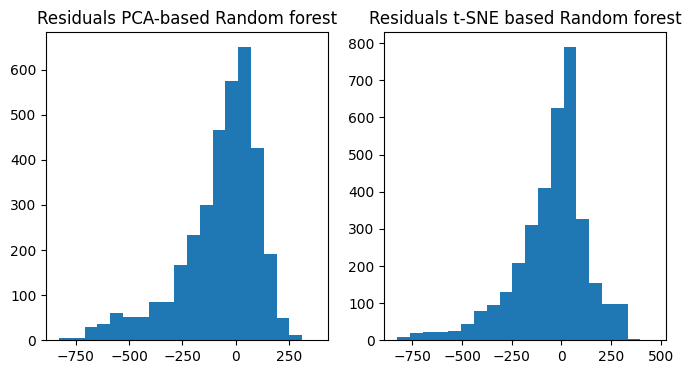

In [39]:
#Residuals
res_pca = pred_pca - y[~msk]
res_tsne = pred_tsne - y[~msk]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Residuals PCA-based Random forest")
plt.hist(res_pca,bins=20)
plt.subplot(1,2,2)
plt.title("Residuals t-SNE based Random forest")
plt.hist(res_tsne,bins=20)
plt.show()

**Exercise 2**

Visualizing with SOM. My solution follows tutorial from https://www.datacamp.com/tutorial/self-organizing-maps


The task was to visualize the MNIST dataset using self-organizing maps.

In [41]:
arrf_file_2 = arff.loadarff("datasets/mnist_784.arff")
df_2 = pd.DataFrame(arrf_file_2[0])

In [42]:
df_2["class"] = df_2["class"].astype(int)
df_2.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [43]:
X = df_2.drop(columns="class")/255
y = df_2["class"].to_numpy()
X = X.to_numpy()

In [44]:
som_x_axis_nodes = 12
som_y_axis_nodes = 12
som_n_variables = X.shape[1]


In [45]:
som = MiniSom(som_x_axis_nodes,som_y_axis_nodes,som_n_variables)

In [46]:
#Parameters and hyperparameters
alpha = 0.5
decay_func = "inverse_decay_to_zero"
sigma0 = 3
sigma_decay_func = "linear_decay_to_one"
heighbourhood_func = "triangle"
distance_func = "cosine"
topology = "rectangular"
random_seed = 314

In [47]:
som = MiniSom(
    som_x_axis_nodes,
    som_y_axis_nodes,
    som_n_variables,
    sigma=sigma0,
    learning_rate=alpha,
    neighborhood_function=heighbourhood_func,
    topology=topology,
    sigma_decay_function=sigma_decay_func,
    decay_function=decay_func,
    random_seed=random_seed

)

In [48]:
N_iterations = 7000
som.train_random(X,N_iterations,verbose=True)

 [ 7000 / 7000 ] 100% - 0:00:00 left 
 quantization error: 5.42916528144772


After training the self-organizing map, 20 000 samples were assigned to winner neurons. These samples were visualized to with their respective classes to identify how well the model could separate the classes.

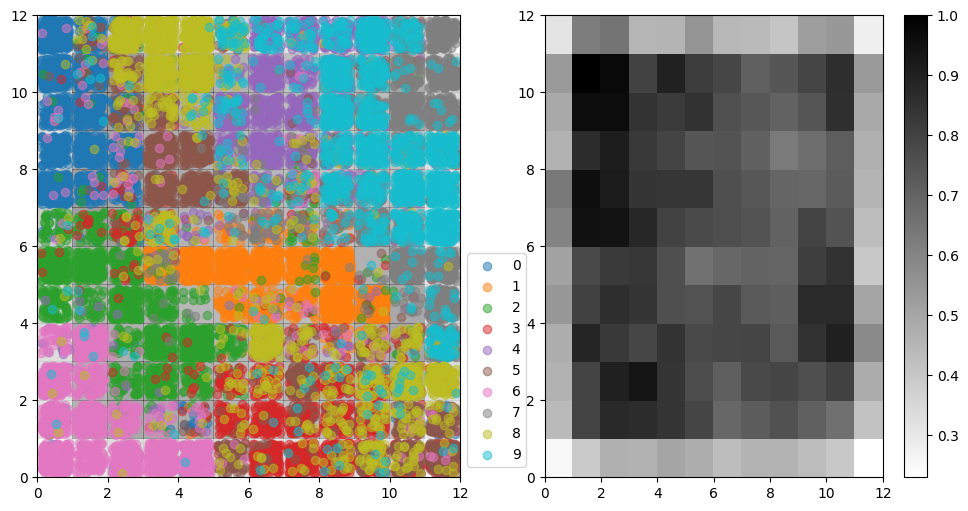

In [52]:
plt.figure(figsize=(12, 6))
n_samples = 20000
sub_y = y[:n_samples]
w_x = np.zeros((n_samples,1))
w_y = np.zeros((n_samples,1))
#Plot the distance map
plt.subplot(1,2,1)
plt.pcolor(som.distance_map().T, cmap='gist_yarg',alpha=0.4) 
colors = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]

#Calculate winner neurons
for i in range(n_samples):
    w_x[i], w_y[i] = som.winner(X[i])
    #Add small uniform noise for visualization
    w_x[i] += 0.5+(0.8*np.random.rand()-0.4)
    w_y[i] += 0.5+(0.8*np.random.rand()-0.4)

#Scatter plots
for c in np.unique(sub_y):
    plt.scatter(w_x[c==sub_y],w_y[c==sub_y],c=colors[c],label=c,alpha=0.5)
plt.legend(loc=2,bbox_to_anchor=(1.0005,0.5))
plt.subplot(1,2,2)
plt.pcolor(som.distance_map().T, cmap='gist_yarg') 
plt.colorbar()
plt.show()


According to the plot. The class 3 is the least separable class compared to others, as the samples from is messed with samples of other classes. Classes 6, 1, 8 and 9 have cells where are there are only samples from one class, but samples are not fully separable. By finding more suitable parameters and hyperparameters, it could be possible to get samples and their classes more separable.
